# Crafting summary statistics

Many simulators produce outputs that are high-dimesional. For example, a simulator might generate a time series or an image. In this notebook, we will focus on hand-crafting summary statistics. We demonstrate that the choice of summary statistics can influence the performance of the inference algorithm.

In [ ]:
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

import numpy as np
import torch
from sbi.utils import MultipleIndependent
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE
from sbi import utils as utils
from sbi.analysis.plot import pairplot
import sdeint

Let us again, first, look at the text messaging example.

In [2]:
figsize(12.5, 3.5)
count_data = np.loadtxt("../data/txtdata.csv")
n_count_data = len(count_data)

We define a simple summary statistics: a moving average, where we can vary the window size

In [3]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float,axis=1)
    ret[:,n:] = ret[:,n:] - ret[:,:-n]
    return ret[:,n - 1:] / n

We also re-define our simulator to make it easier to extract summary statistics

In [4]:
def simulator(params):
        #data = np.r_[stats.poisson.rvs(mu=params[0], size=int(params[2])), stats.poisson.rvs(mu=params[1], size=74 - int(params[2]))]
        #data=torch.cat(torch.poisson(params[:,0].unsqueeze(1).repeat(1,int(params[2]))),torch.poisson(params[:,1].unsqueeze(1).repeat(1,74-int(params[2]))),axis=1)
        data = torch.empty(0)
        for i in range(params.shape[0]):
            data1=torch.cat((torch.poisson(params[i,0].unsqueeze(0).repeat(1,int(params[i,2]))),torch.poisson(params[i,1].unsqueeze(0).repeat(1,74-int(params[i,2])))),axis=1)
            data=torch.cat((data,data1),axis=0)
        return data
    

alpha=1./20.    
prior=MultipleIndependent(
    [
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Exponential(rate=torch.ones(1)*0.05),
        torch.distributions.Uniform(low=torch.Tensor([0.0]),high=torch.Tensor([70.0]))
    ]
)

We apply our summary statistics to create inputs for the sbi inference

In [5]:
theta = prior.sample((10000,))
x=moving_average(simulator(theta),n=5)

theta = torch.as_tensor(theta, dtype=torch.float32)
x = torch.as_tensor(x, dtype=torch.float32)

In [6]:
inference = SNPE(prior)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 102 epochs.

Importantly, summary statistics has also to be applied to the observed data

In [87]:
observation=moving_average(torch.from_numpy(count_data).unsqueeze(0),n=5)

In [8]:
samples = posterior.sample((10000,), x=observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

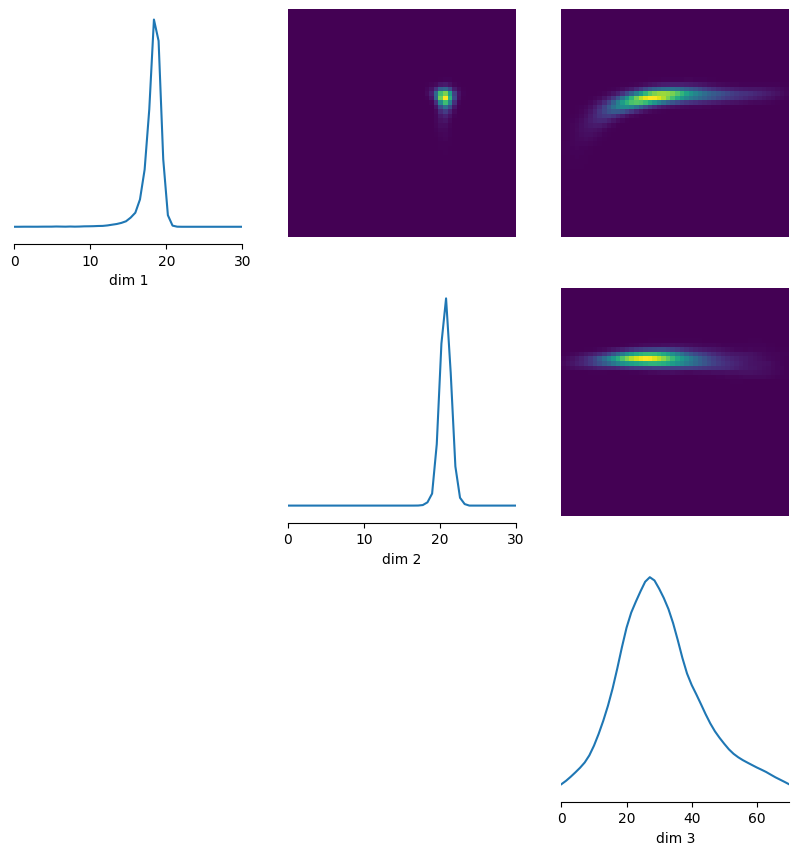

In [9]:
fig, out = pairplot(samples, limits=[[0,30],[0,30],[0,70]], fig_kwargs={'fig_size':(3,3)}, upper='kde', diag='kde')

we can also see how the window size of our moving average influences the inference when plotting expected number of messages

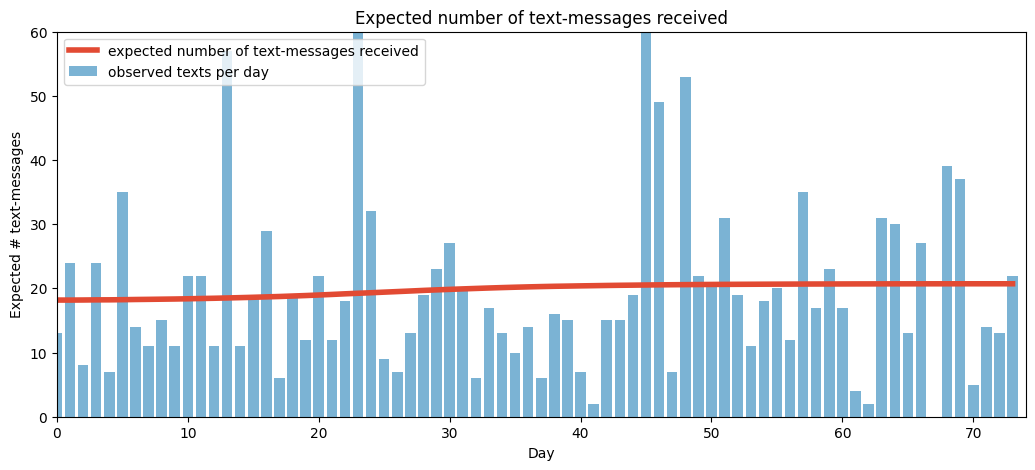

In [10]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < samples[:,2]
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (samples[ix,0].sum()
                                   + samples[~ix,1].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")
plt.show()


# Define a simulator: Lotka-Volterra


Now let us look at another example, where it makes sense to derive a slightly more complex summary statistics.

The Lotka-Volterra (aka Prey-Predator) model is a model that describes the evolution of the population of two species (e.g. foxes and rabbits):

$\frac{du}{dt} = au - buv + \epsilon$  
$\frac{dv}{dt} = -cv + dbuv + \epsilon$

```
| a   | prey reproduction rate |
| b   | prey death rate per predator |
| c   | predator death rate (if no prey) |
| d   | predators born per prey |
```
```
| u   | prey / rabbits
| v   | predator / foxes
```
$\epsilon$ is Gaussian noise.

Code taken from: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html

In [11]:
t = np.linspace(0, 15, 1000)      # time
X0 = np.array([10.0, 5.0])        # initials conditions: 10 rabbits and 5 foxes


Let's assume that we observe the evolution of the population and we want to infer the parameters $a$ and $b$ (assume that $c$ and $d$ are known).

In [12]:
def run_model(theta):
    a = theta[0]
    b = theta[1]
    c = 1.5
    d = 0.75
    
    def dX_dt(X, t):
        return np.array([ a*X[0] -   b*X[0]*X[1] ,
                      -c*X[1] + d*b*X[0]*X[1] ])
    def dW(x, t):
        return 0.7 * np.eye(2)  # Gaussian noise

    X = sdeint.itoint(dX_dt, dW, X0, t)
    return X

Now let us display how the traces for a given set of parameters will look like

In [13]:
theta = [3.3, 0.29]  # parameters (a, b)
X = run_model(theta)

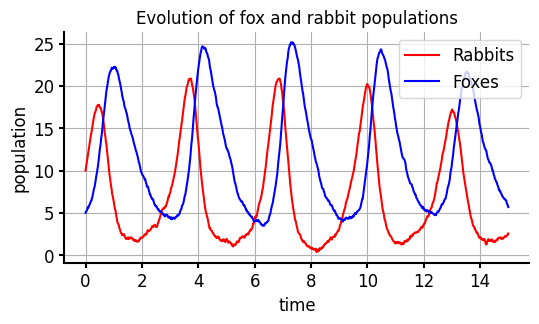

In [14]:
with mpl.rc_context(fname=".matplotlibrc"):
    rabbits, foxes = X.T
    f1 = plt.subplots(1, 1, figsize=(6, 3))
    plt.plot(t, rabbits, 'r-', label='Rabbits')
    plt.plot(t, foxes  , 'b-', label='Foxes')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('population')
    plt.title('Evolution of fox and rabbit populations')
    plt.savefig("xo_lotka.png", dpi=200, bbox_inches="tight")
    plt.show()

We will use the means, variances, autocorrelations, and cross-correlation of the two traces as summary statistics

In [15]:
def summstats(trace):
    rabbits_mean = [np.mean(trace[:, 0])]
    foxes_mean = [np.mean(trace[:, 1])]
    rabbits_variance = [np.var(trace[:, 0])]
    foxes_variance = [np.var(trace[:, 1])]
    autocorr_rabbits1 = [np.correlate(trace[:, 0], trace[:, 0], "full")[100]]
    autocorr_rabbits2 = [np.correlate(trace[:, 0], trace[:, 0], "full")[200]]
    autocorr_foxes1 = [np.correlate(trace[:, 1], trace[:, 1], "full")[100]]
    autocorr_foxes2 = [np.correlate(trace[:, 1], trace[:, 1], "full")[200]]
    cross_corr = np.correlate(trace[:, 0], trace[:, 1])
    
    summ_stats = np.concatenate(
        [
            rabbits_mean, foxes_mean, rabbits_variance, foxes_variance, 
            autocorr_rabbits1, autocorr_rabbits2, 
            autocorr_foxes1, autocorr_foxes2, cross_corr
        ]
    )
    return summ_stats

We will now define a uniform prior on the paramaters

In [16]:
lower_bound = torch.tensor([0.5, 0.0])
upper_bound = torch.tensor([3.5, 0.5])
prior = utils.BoxUniform(lower_bound, upper_bound)

We start with a very low number of simulations in order to demonstrate its effect on the posterior.

In [17]:
N = 50  # number of simulations

thetas = prior.sample((N,))
xs = []
for theta in thetas:
    trace = run_model(theta)
    summ_stats = summstats(trace)
    xs.append(summ_stats)
xs = np.stack(xs)

Run this cell in the interest of time to use the pre-computed simulation results to see how the number of simulations affect the posterior

In [18]:
num_simulations = 5000
thetas = np.load("../data/theta_5000.npy")[:num_simulations]
xs = np.load("../data/x_5000.npy")[:num_simulations]

In [19]:
print("The summary statistics of the 1st simulation: ", xs[0])
print("The summary statistics of the 8th simulation: ", xs[7])

The summary statistics of the 1st simulation:  [4.78850591e+00 6.72760781e+00 1.33920043e+01 1.39270371e+01
 2.85946865e+03 3.03612770e+03 1.01477683e+04 6.91353543e+03
 3.20327756e+04]
The summary statistics of the 8th simulation:  [3.51551567e+01 4.70024429e+01 2.21375268e+03 2.22976764e+03
 3.66197800e+04 8.67747207e+05 7.47937268e+04 1.10897909e+06
 1.56947283e+06]


We need to ensure there is no `nan` and `Inf` values in the vaues we are going to pass to the sbi inference

In [20]:
contains_no_nan = np.invert(np.any(np.isnan(xs), axis=1))
thetas_train = thetas[contains_no_nan]
xs_train = xs[contains_no_nan]

In [21]:
contains_no_inf = np.invert(np.any(xs_train < -1e6, axis=1))
thetas_train = thetas_train[contains_no_inf]
xs_train = xs_train[contains_no_inf]

contains_no_inf = np.invert(np.any(xs_train > 1e6, axis=1))
thetas_train = thetas_train[contains_no_inf]
xs_train = xs_train[contains_no_inf]

Convert `thetas` and `xs` to pytorch tensors

In [22]:
thetas_torch = torch.as_tensor(thetas_train, dtype=torch.float32)
xs_torch = torch.as_tensor(xs_train, dtype=torch.float32)
xs_torch=xs_torch[:3500,:]
thetas_torch=thetas_torch[:3500,:]

In [23]:
inference = SNPE(prior)
_ = inference.append_simulations(thetas_torch, xs_torch).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 95 epochs.

Now we need to define the trace we will treat as an observation. In this case we do not have real data, so we will generate ones using our simulator (which is obviously a good sanity check for a model in general)

In [24]:
gt = [1.5, 0.2]  # not known in real problems.
xo_trace = run_model(gt)
xo = summstats(xo_trace)
xo = torch.as_tensor(xo, dtype=torch.float32)

In [25]:
samples = posterior.sample((10000,), x=xo)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

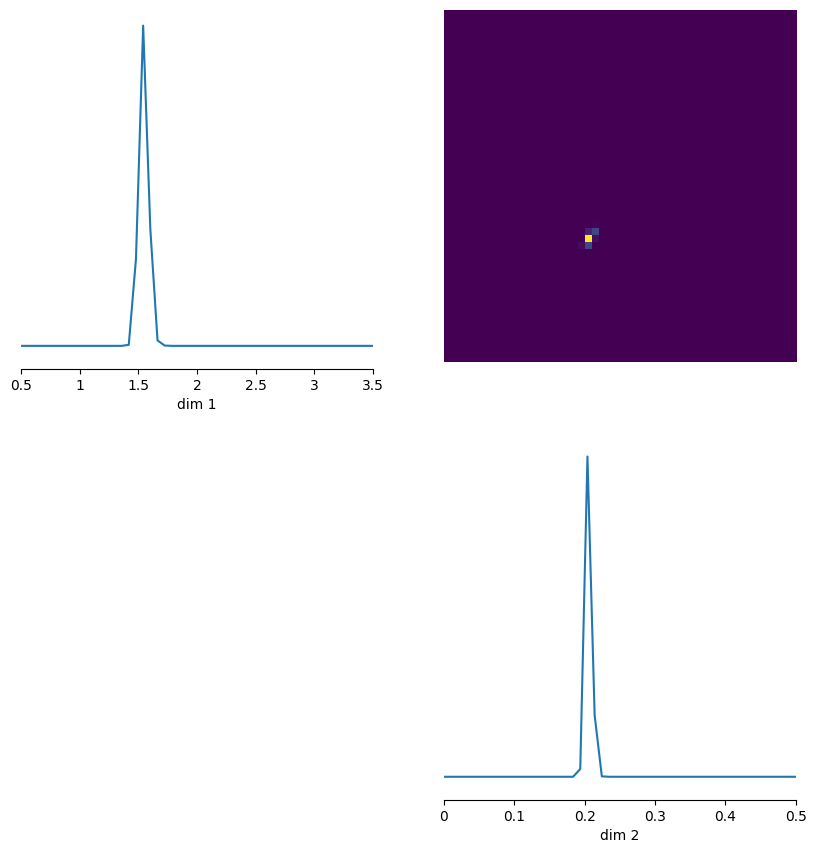

In [26]:
fig, out = pairplot(samples, limits=[[0.5,3.5],[0,0.5]], fig_kwargs={'fig_size':(2,2)}, upper='kde', diag='kde')

# How to distribute to multiple nodes?

Use ray cluster (read [getting started with ray](https://docs.ray.io/en/latest/cluster/getting-started.html)) for that!

The `sbi` package needs a slight modification to be parallelized with `ray` as backend.

One option is to modify the `sbi` source file `sbi/simulators/simutils.py`. Another one is to use a modified version of the `simulate_for_sbi` function.

Afterwards, you may use use a batch script specific to ray clusters:  [documentation for slurm headers in ray](https://docs.ray.io/en/latest/cluster/vms/user-guides/community/slurm.html#ray-slurm-headers)

We provide a batch script which works on our system under `run_ray.sbatch`
### - Use a patched version of `simulate_for_sbi`
You may find an `sbi_patch.py` file in the main folder of this repo, which has the modified `simulate_for_sbi` function. 

In your code, you may replace 

```python 
from sbi.utils.simulation_utils import simulate_for_sbi
```
with 
```python
from sbi_patch import simulate_for_sbi
```

having the `sbi_patch.py` file in your python path or in your local folder. 

### - Modify sbi package option

Another option would be to perform these changes directly in your installation of the `sbi` package. 

Wrap the lines

```python
simulation_outputs = Parallel(n_jobs=num_workers)(
    delayed(simulator_seeded)(batch, batch_seed)
    for batch, batch_seed in zip(batches, batch_seeds)
    )
```

with 

```python
from ray.util.joblib import register_ray

register_ray()

with joblib.parallel_backend('ray'):
    simulation_outputs = Parallel(n_jobs=num_workers)(
        delayed(simulator_seeded)(batch, batch_seed)
        for batch, batch_seed in zip(batches, batch_seeds)
        )
```